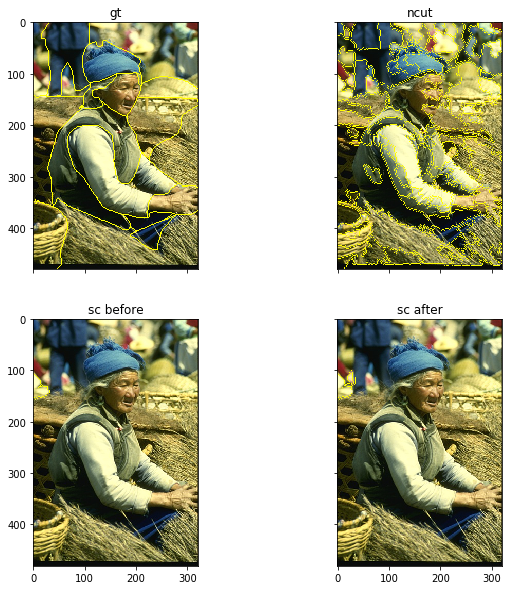

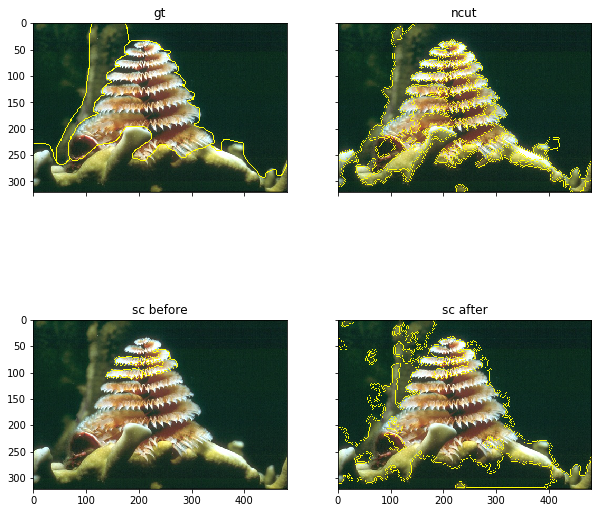

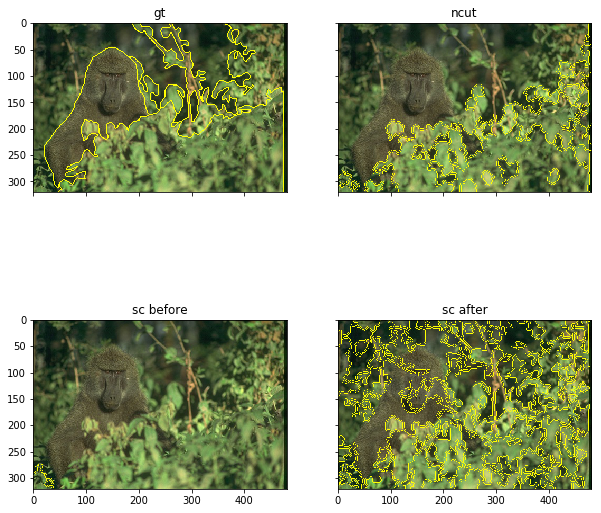

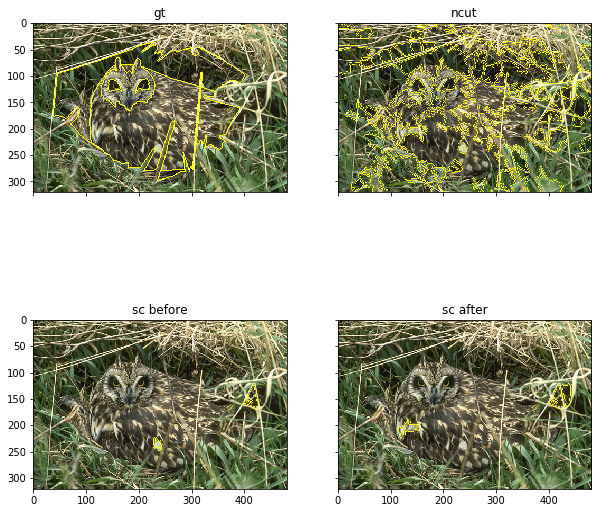

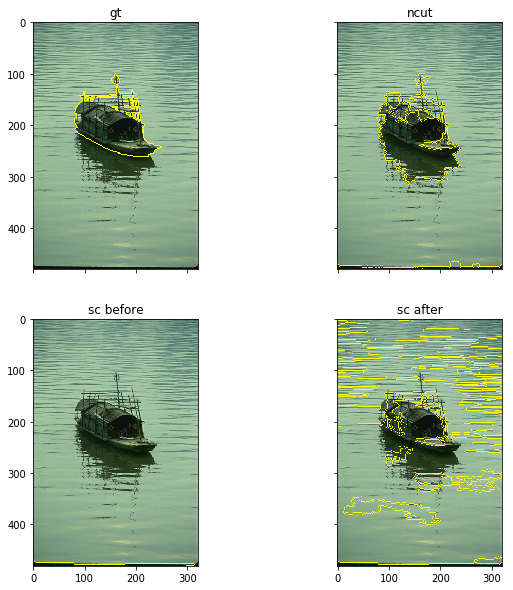

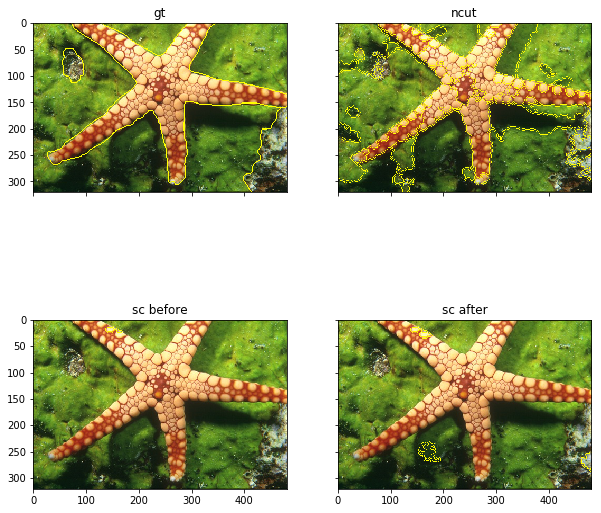

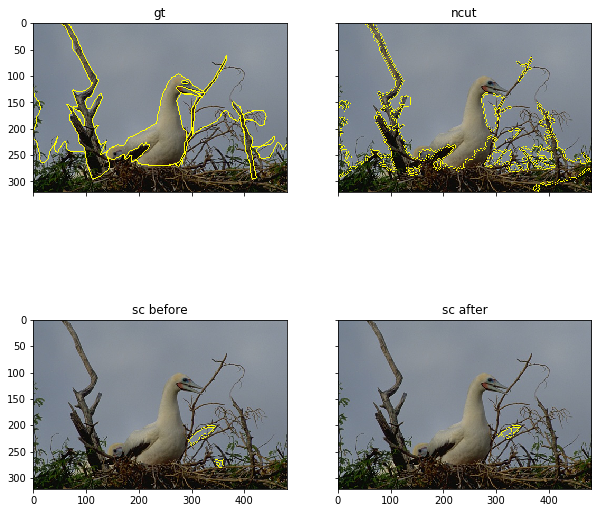

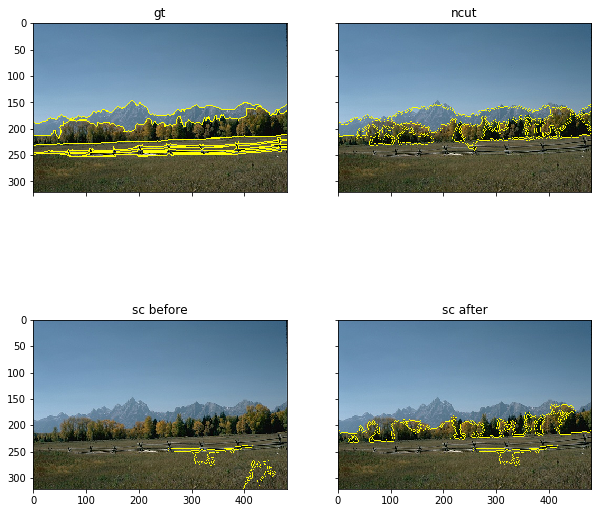

In [3]:
# image eigenvector
import scipy
import skimage
from skimage.segmentation import felzenszwalb, mark_boundaries, slic
from os.path import basename, join, isfile
import os
import matplotlib.pyplot as plt    
from image_segmentation import large_image_seg
from imageio import imread, imwrite
import cv2
from scipy.io import loadmat
from skimage.segmentation import mark_boundaries, find_boundaries

%matplotlib inline


def ncut(img=None, thresh=0.001, num_cuts=10, sp_met='slic'):
    from skimage import data, segmentation, color
    from skimage.future import graph
    
#     labels1 = segmentation.felzenszwalb(m_img, scale=50, sigma=0.5, min_size=100)
    if sp_met == 'slic':
        labels1 = segmentation.slic(img, compactness=30, n_segments=400)
    if sp_met == 'fl':
        labels1 = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
    if sp_met == 'qs':
        labels1 = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
    
    out1 = color.label2rgb(labels1, img, kind='avg')

    g = graph.rag_mean_color(img, labels1, mode='similarity')
    labels2 = graph.cut_normalized(labels1, g, thresh=thresh, num_cuts=num_cuts)
    out2 = color.label2rgb(labels2, img, kind='avg')
    
    return labels2


gt_dir = './segment_result_gt'
sc_dir = './segment_result_before'
pro_sc_dir = './segment_result_after'
ncut_dir = './segment_result_ncut'

basename = os.getcwd()
img_dir = join(basename, 'input')
img_list = [join(img_dir, f) for f in os.listdir(img_dir) if isfile(join(img_dir, f))]

# save path 

# vis part
for img_path in img_list:
    
    if img_path[-3:] == 'jpg':
        img = imread(img_path)
        
        # 1. 之前方法
#         p_label = large_image_seg(img_path=img_path, sp_num=1000, sp_mode="similarity", sp_connectivity=3, \
#                                  graph_met='lib_met', admm_met='admm', num_cuts=5)  
# #         p_label2 = large_image_seg(img_path=img_path, sp_num=1000, sp_mode="distance", sp_connectivity=3, \
# #                                  graph_met='syn_met', admm_met='density_admm', num_cuts=2)

#         # show boundary
#         plt.figure()
#         plt.imshow(mark_boundaries(img, p_label))
#         plt.show()
                
#         from skimage import data, io, segmentation, color
#         out = color.label2rgb(p_label, img, kind='avg')
#         out = segmentation.mark_boundaries(out, p_label, (0, 0, 0))
#         io.imshow(out)
#         io.show()
        
    
        # 1. original method
        p_label_1 = large_image_seg(img_path=img_path, sp_num=100, sp_mode="similarity", sp_connectivity=1, \
                                 graph_met='lib_met', admm_met='admm', num_cuts=2, merge=False)  

#         # show boundary
#         from skimage import data, io, segmentation, color
#         out = color.label2rgb(p_label, img, kind='avg')
#         out = segmentation.mark_boundaries(out, p_label, (0, 0, 0))
#         io.imshow(out)
#         io.show()
        
#         plt.imshow(mark_boundaries(img, p_label))
#         plt.show()
        
        # save the ori-method
#         img_name = './segment_result_before/' + img_path.split('/')[-1]
#         imwrite(img_name, p_label)
#         cv2.imwrite(img_name, np.uint64(p_label))

        # 2. add the distance measurement, 优化测度
#         p_label = large_image_seg(img_path=img_path, sp_num=100, sp_mode="similarity", sp_connectivity=3, \
#                                  graph_met='syn_met', admm_met='admm', num_cuts=5, merge=False, \
#                                  dist_hist=True)  
#         p_label = p_label.astype(np.uint8)
        
        p_label_2 = large_image_seg(img_path=img_path, sp_num=100, sp_mode="similarity", sp_connectivity=3, \
                                 graph_met='lib_met', admm_met='admm', num_cuts=3, merge=False)  
        
#         # show boundary
#         from skimage import data, io, segmentation, color
#         out = color.label2rgb(p_label, img, kind='avg')
#         out = segmentation.mark_boundaries(out, p_label, (0, 0, 0))
#         io.imshow(out)
#         io.show()
        
#         plt.imshow(mark_boundaries(img, p_label))
#         plt.show()
        
        # save the optimization method
#         img_name = './segment_result_after/' + img_path.split('/')[-1]
#         imwrite(img_name, p_label)
#         cv2.imwrite(img_name, np.uint64(p_label))

        # plot segmentation:
        segment_img = imread(img_path)
#       print(segment_img.dtype)

        # get .mat name and convert to numpy type
        gt_name = img_path.split('/')[-1].split('.')[0] + '.mat'
        gt_path = join(gt_dir, gt_name)
        if isfile(gt_path):
            gt_dict = loadmat(gt_path)
        else:
            print('no .mat files')

        gt_mat = gt_dict['groundTruth']
        segments_gt = gt_mat[0, gt_mat.shape[1]-1][0, 0][0]
        
        img_name = img_path.split('/')[-1].split('.')[0] + '.jpg'
        
        img = imread(os.path.join(img_dir, img_name))
        segments_ncut = ncut(segment_img)
        
#         segments_ncut = imread(os.path.join(ncut_dir, img_name))
# #         segments_before = imread(os.path.join(sc_dir, img_name))
# #         segments_after = imread(os.path.join(pro_sc_dir, img_name))
#         segments_before = imread(os.path.join(pro_sc_dir, img_name))
#         segments_after = imread(os.path.join(sc_dir, img_name))
# #         print(segments_ncut)
        
        # plot segmentation
        fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
        ax[0, 0].imshow(mark_boundaries(img, segments_gt))
        ax[0, 0].set_title("gt")
        ax[0, 1].imshow(mark_boundaries(img, find_boundaries(segments_ncut)))
        ax[0, 1].set_title('ncut')
        ax[1, 0].imshow(mark_boundaries(img, find_boundaries(p_label_1)))
        ax[1, 0].set_title('sc before')
        ax[1, 1].imshow(mark_boundaries(img, find_boundaries(p_label_2)))
        ax[1, 1].set_title('sc after')
        plt.show()
        
        
        # 3. add merge method, 优化稀疏系数
#         for merge in [2,3,4]:
#             p_label = large_image_seg(img_path=img_path, sp_num=1000, sp_mode="similarity", sp_connectivity=3, \
#                                      graph_met='syn_met', admm_met='admm', num_cuts=5, merge=merge)  

#             # show boundary
#     #             plt.figure()
#     #             plt.imshow(mark_boundaries(img, p_label))
#     #             plt.show()
#             from skimage import data, io, segmentation, color
#             out = color.label2rgb(p_label, img, kind='avg')
#             out = segmentation.mark_boundaries(out, p_label, (0, 0, 0))
#             io.imshow(out)
#             io.show()

        
#         # 2. 校正
#         var_p_label = large_image_seg(img_path=img_path, sp_num=1000, sp_mode="distance", sp_connectivity=3, \
#                                  graph_met='syn_met', admm_met='var_admm', num_cuts=10)
#         plt.figure()
#         plt.imshow(mark_boundaries(img, var_p_label))
#         plt.show()
#         out = color.label2rgb(var_p_label, img, kind='avg')
#         out = segmentation.mark_boundaries(out, var_p_label, (0, 0, 0))
#         io.imshow(out)
#         io.show()
    
        # evalaute
        
# EM: admm + variation


In [7]:
import os
from evaluate import evaluate

# do the evaluate
gt_dir = './segment_result_gt'
sc_dir = './segment_result_before'
pro_sc_dir = './segment_result_after'
ncut_dir = './segment_result_ncut'

for soft_thres in range(3, 6):
    print(soft_thres)
    b_precision, b_recall, b_F = evaluate(sc_dir, gt_dir, soft_thres=soft_thres)
    a_precision, a_recall, a_F = evaluate(pro_sc_dir, gt_dir, soft_thres=soft_thres)
    n_precision, n_recall, n_F = evaluate(ncut_dir, gt_dir, soft_thres=soft_thres-2)

    print('sc: ', a_precision.mean(), a_recall.mean(), a_F.mean())
    print('improvaed sc: ', b_precision.mean(), b_recall.mean(), b_F.mean())
    print('ncut: ', n_precision.mean(), n_recall.mean(), n_F.mean())


    



3
sc:  0.3826277027404472 0.8041282932993037 0.4944279293505214
improvaed sc:  0.3574074918010162 0.9121213331703366 0.49337270938023403
ncut:  0.2720653598269388 0.8433387311597877 0.39912488620328634
4
sc:  0.41812372098608613 0.8427919055765491 0.5336018589567841
improvaed sc:  0.39376889984696606 0.9365799268272826 0.5334230566229794
ncut:  0.37757416236992625 0.8995972617678156 0.5175643888887339
5


KeyboardInterrupt: 

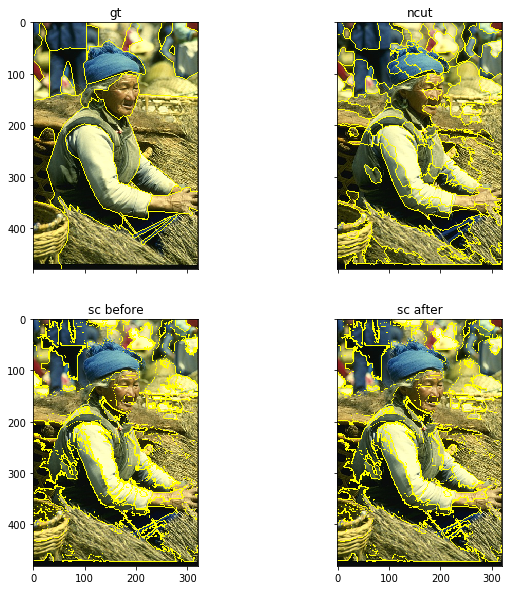

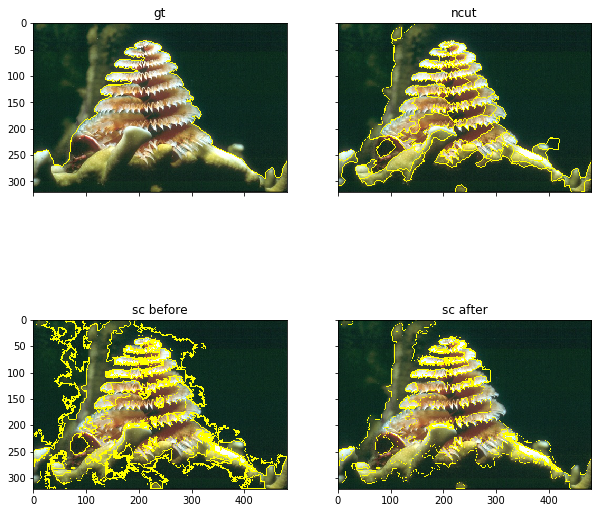

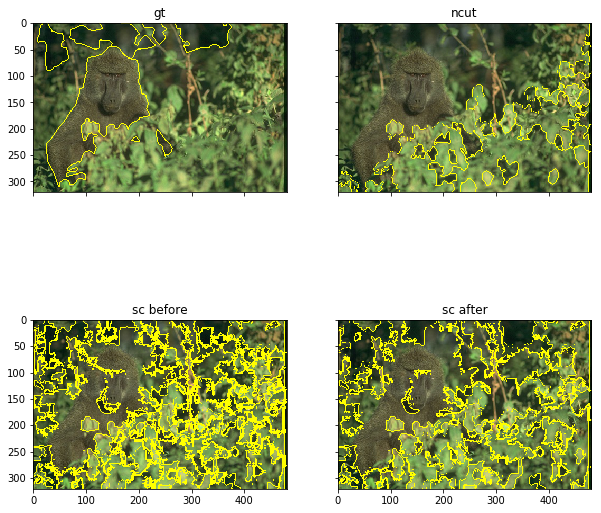

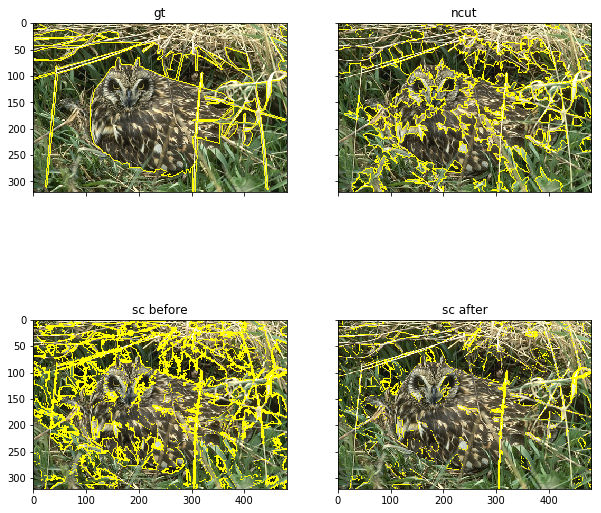

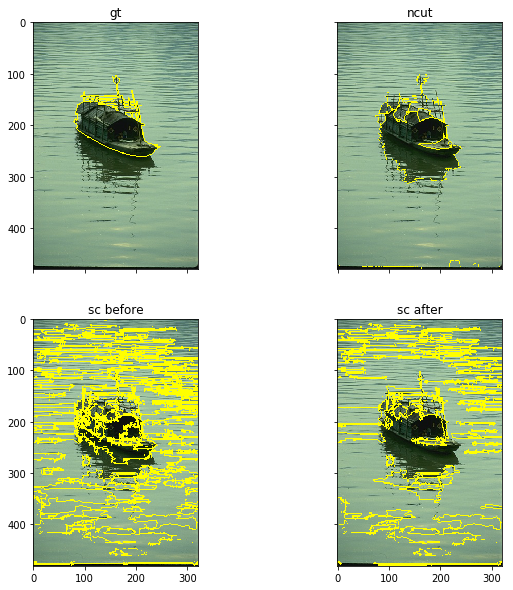

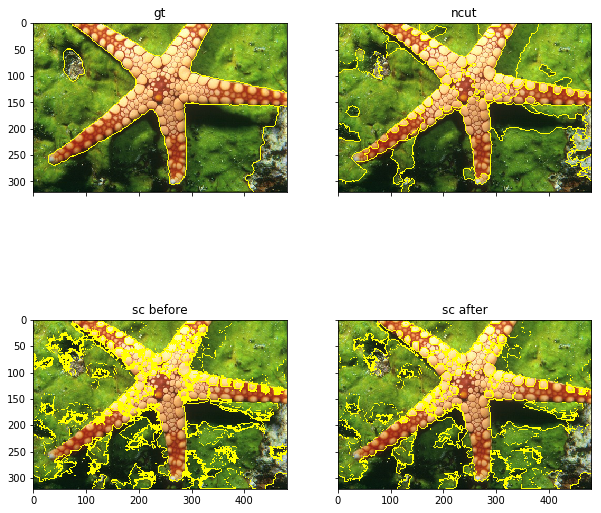

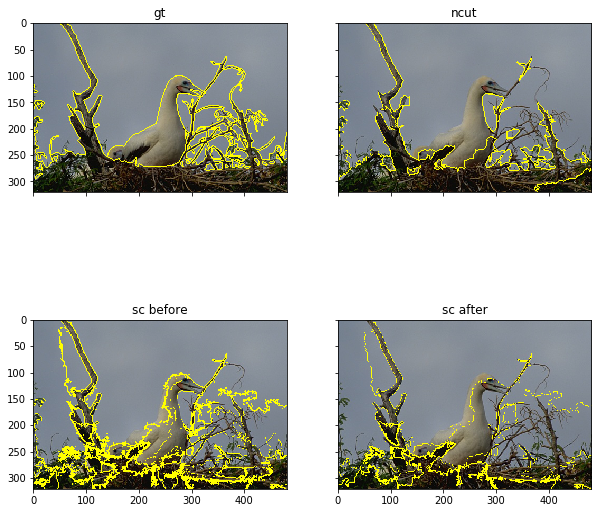

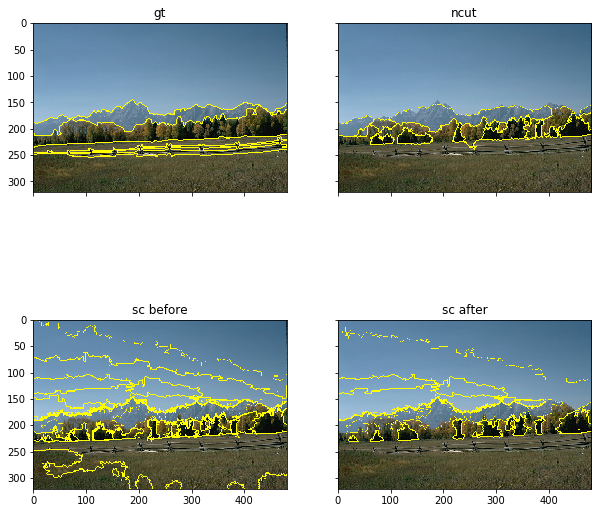

In [6]:
# vis segmentation
import matplotlib.pyplot as plt
from imageio import imread, imwrite
from os.path import basename, join, isfile
import os
from scipy.io import loadmat
from skimage.segmentation import mark_boundaries, find_boundaries
import numpy as np
from skimage import img_as_ubyte
%matplotlib inline

def ncut(img=None, thresh=0.001, num_cuts=10, sp_met='slic'):
    from skimage import data, segmentation, color
    from skimage.future import graph
    
#     labels1 = segmentation.felzenszwalb(m_img, scale=50, sigma=0.5, min_size=100)
    if sp_met == 'slic':
        labels1 = segmentation.slic(img, compactness=30, n_segments=400)
    if sp_met == 'fl':
        labels1 = segmentation.felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
    if sp_met == 'qs':
        labels1 = segmentation.quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
    
    out1 = color.label2rgb(labels1, img, kind='avg')

    g = graph.rag_mean_color(img, labels1, mode='similarity')
    labels2 = graph.cut_normalized(labels1, g, thresh=thresh, num_cuts=num_cuts)
    out2 = color.label2rgb(labels2, img, kind='avg')
    
    return labels2

gt_dir = './segment_result_gt'
sc_dir = './segment_result_before'
pro_sc_dir = './segment_result_after'
ncut_dir = './segment_result_ncut'

img_dir = './input'

img_list = [join(img_dir, f) for f in os.listdir(img_dir) if isfile(join(img_dir, f))]
precision_array, recall_array, F_array = [], [], []


for img_path in img_list:
    if img_path[-3:] == 'jpg':
#             print(img_path)
        segment_img = imread(img_path)
#             print(segment_img.dtype)

        # get .mat name and convert to numpy type
        gt_name = img_path.split('/')[-1].split('.')[0] + '.mat'
        gt_path = join(gt_dir, gt_name)

        if isfile(gt_path):
            gt_dict = loadmat(gt_path)
        else:
            print('no .mat files')

        gt_mat = gt_dict['groundTruth']
#         segments_gt = gt_mat[0, gt_mat.shape[1]-1][0, 0][0]
        segments_gt = gt_mat[0, 0][0, 0][0]

        img_name = img_path.split('/')[-1].split('.')[0] + '.jpg'
        
        img = imread(os.path.join(img_dir, img_name))
        segments_ncut = ncut(segment_img)
        
#         segments_ncut = imread(os.path.join(ncut_dir, img_name))
#         segments_before = imread(os.path.join(sc_dir, img_name))
#         segments_after = imread(os.path.join(pro_sc_dir, img_name))
        segments_before = imread(os.path.join(pro_sc_dir, img_name))
        segments_after = imread(os.path.join(sc_dir, img_name))
#         print(segments_ncut)
    
        # plot segmentation
        fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
        ax[0, 0].imshow(mark_boundaries(img, segments_gt))
        ax[0, 0].set_title("gt")
        ax[0, 1].imshow(mark_boundaries(img, segments_ncut))
        ax[0, 1].set_title('ncut')
        ax[1, 0].imshow(mark_boundaries(img, segments_after))
        ax[1, 0].set_title('sc before')
        ax[1, 1].imshow(mark_boundaries(img, segments_before))
        ax[1, 1].set_title('sc after')
        plt.show()
        

In [4]:
# image eigenvector
import scipy
import skimage
from skimage.segmentation import felzenszwalb, mark_boundaries, slic
from os.path import basename, join, isfile
import os
import matplotlib.pyplot as plt    
from image_segmentation import large_image_seg
from imageio import imread, imwrite
import numpy as np
from sklearn.cluster import spectral_clustering
from numpy import linalg as LA
from skimage import img_as_float

%matplotlib inline

basename = os.getcwd()
img_dir = join(basename, 'input')
img_list = [join(img_dir, f) for f in os.listdir(img_dir) if isfile(join(img_dir, f))]


def ncut(img=None, thresh=0.001, num_cuts=10, sp_met='fl'):
    from skimage import data, segmentation, color
    from skimage.future import graph
    
#     labels1 = segmentation.felzenszwalb(m_img, scale=50, sigma=0.5, min_size=100)
    if sp_met == 'slic':
        labels1 = segmentation.slic(img, compactness=30, n_segments=400)
    if sp_met == 'fl':
        labels1 = image_segmentation.felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
    if sp_met == 'qs':
        labels1 = image_segmentation.quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
    
    out1 = color.label2rgb(labels1, img, kind='avg')

    g = graph.rag_mean_color(img, labels1, mode='similarity')
    labels2 = graph.cut_normalized(labels1, g, thresh=thresh, num_cuts=num_cuts)
    out2 = color.label2rgb(labels2, img, kind='avg')
    
    return labels2


import cv2

# vis part
for img_path in img_list:
    if img_path[-3:] == 'jpg':
        img = imread(img_path)
        segments_ncut = ncut(img, sp_met='slic')
        print(segments_ncut.dtype)
        img_name = './segment_result_ncut/' + img_path.split('/')[-1]
#         imwrite(img_name, segments_ncut)
        
        cv2.imwrite(img_name, segments_ncut)



image segmentation method

for image segmentation:


int64
int64
int64
int64
int64
int64
int64
int64


In [4]:
import numpy as np
np.asarray([1,2]).mean()

1.5

In [8]:
import numpy as np
%matplotlib inline
from imageio import imread


def hist(img_path):
    # reads an input image, color mode
    img = imread(img_path) 
    print(img[:,:,0].shape)
    
    color_hist = []
    # find frequency of pixels in range 0-255, calculate histogram of blue, green or red channel respectively.
    for i in range(3):
        histr, bins = np.histogram(img[:,:,i].ravel(), bins=np.arange(257))

        histr = np.reshape(histr, (16, 16)) # 16 bins
        histr = np.sum(histr, axis=1)  
        
        color_hist.append(histr)
        
    hist = normalize(color_hist).flatten()
    hist = np.asarray(hist)
    return hist

hist1 = hist('24063.jpg')
hist2 = hist('12003.jpg')
print(hist1.shape, hist2.shape)
from scipy.spatial import distance
diff = distance.cityblock(hist1, hist2)
print(diff)

FileNotFoundError: No such file: '/home/yorickyyt/image_segmentation/Superpixels/24063.jpg'

In [ ]:
# importing required libraries of opencv 
import cv2 
import numpy as np

%matplotlib inline
# importing library for plotting 
from matplotlib import pyplot as plt 
from sklearn.preprocessing import normalize
  

# # reads an input image 
# from imageio import imread
# img = imread('24063.jpg') 
# img = img[:3,:2]
# print(img)
# print(img.dtype)

# # img = cv2.imread('24063.jpg',1) 
# # img = np.asarray(img)
# print(img.shape)

# img = np.float32(img)



def hist(img_path):
    # reads an input image, color mode
    img = cv2.imread(img_path, 1) 
    
    color_hist = []
    # find frequency of pixels in range 0-255, calculate histogram of blue, green or red channel respectively.
    for i in range(3):
        histr = cv2.calcHist([img],[i],None,[256],[0,256]) 
        histr = np.reshape(histr, (16, 16)) # 16 bins
        histr = np.sum(histr, axis=1)  
        
        color_hist.append(histr)
        
    hist = normalize(color_hist).flatten()
    hist = np.asarray(hist)
    return hist

hist1 = hist('24063.jpg')
hist2 = hist('12003.jpg')
print(hist1.shape, hist2.shape)
from scipy.spatial import distance
diff = distance.cityblock(hist1, hist2)
print(diff)